In [20]:
import pandas as pd

# read data
reviews_df =pd.read_excel(r'C:\Datascience\NPS_Spring_2019.xlsx')
reviews_df = reviews_df[reviews_df['REL: Comment: Recommend'].notnull()]

reviews_df.head()

,Response Received Date,First Name,Last Name,Company,Contact Email,Primary Phone Number,Primary Mobile Phone Number,Primary Job Role Title,Primary addr city name,Primary addr state code,...,Director - JATA,CSS - Dragon,Analyst - Quality,Consultant - Quality,Epic Service Owner,iScribes Account Manager,Follow-up Status,Modified,Modified By,List Source
0,2019-06-19 18:31:16,Evaleen,Holden,BAYCARE Health System (Baycare),evaleen.holden@baycare.org,813-870-4681,NaN,HIM/Transcription Project Lead,NaN,FL,...,NaN,NaN,Not Quality,NaN,NaN,NaN,Open,2019-03-14 01:54:00,"Gillin, Kathleen",SharePoint
2,2019-05-24 17:42:03,Lynn,Sweeney,Royal Victoria Regional Health Centre,sweeneyl@rvh.on.ca,705-728-9090 x42648,NaN,"Manager, Health Records",NaN,NaN,...,NaN,NaN,Not Quality,NaN,NaN,NaN,Closed,2019-03-29 11:41:00,"Lakin, Amanda",SharePoint
3,2019-05-14 18:20:50,Jamie,Moncato,HCA Richmond,jamie.moncato@parallon.com,843-748-0569,NaN,Regional Transcription Manager,NaN,GA,...,NaN,NaN,NaN,NaN,NaN,NaN,Open,2019-03-28 05:47:00,"Kannan, Sudhir",SharePoint
6,2019-05-14 11:19:11,Julie,Alverson,Bon Secours Charity Health System,julie_alverson@bshsi.org,(845) 368-5703,NaN,System CDMP Manager,Suffern,NY,...,julie.anzalone@nuance.com,NaN,NaN,NaN,NaN,NaN,Closed,2019-03-19 00:00:00,Karen Starr,CDI
8,2019-05-07 18:13:27,Lynn,Muserelli,Adventist Health West - Tillamook,muserel01@ah.org,503-251-6266 X5978,NaN,HIM Director,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Open,2019-03-26 11:48:00,"Walters, Sherri",SharePoint


In [21]:
# create the label
reviews_df["is_bad_review"] = reviews_df["NPS Score"].apply(lambda x: 1 if x < 5 else 0)
# select only relevant columns

reviews_df = reviews_df[["REL: Comment: Recommend", "is_bad_review"]]
reviews_df.head()

,REL: Comment: Recommend,is_bad_review
0,"After having worked with other companies, i fo...",0
2,Customer Service from Amanda Lakin and Kim Wie...,0
3,"I know the question states primary but, I have...",0
6,Great all around and technical support,0
8,Their attention to customer service - very qui...,0


In [22]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\santosh_sankan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santosh_sankan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\santosh_sankan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\santosh_sankan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [23]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [24]:
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [25]:
# clean text data
reviews_df["review_clean"] = reviews_df["REL: Comment: Recommend"].apply(lambda x: clean_text(x))

In [26]:
reviews_df.iloc[580]["review_clean"]

'ask customer success specialist chethan kumar reduce number license pay enough user use dosent know moreover case open figure hasent gotten answer month'

In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["REL: Comment: Recommend"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)


In [28]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["REL: Comment: Recommend"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["REL: Comment: Recommend"].apply(lambda x: len(x.split(" ")))

In [29]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [30]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

In [31]:
# show is_bad_review distribution
reviews_df["is_bad_review"].value_counts(normalize = True)

0    0.942177
1    0.057823
Name: is_bad_review, dtype: float64

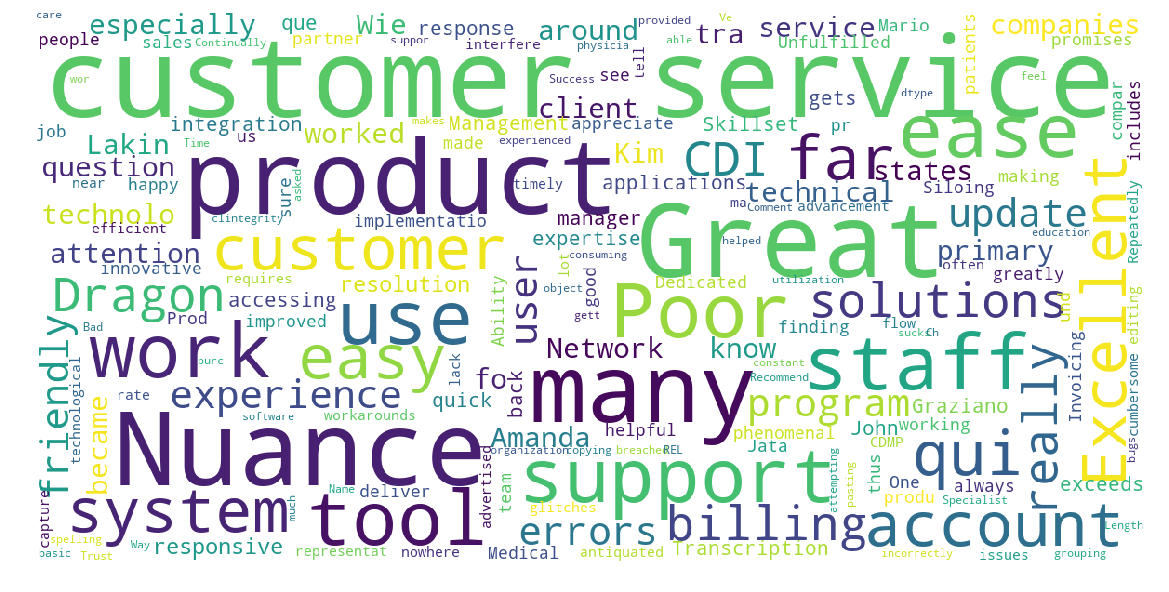

In [32]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["REL: Comment: Recommend"])

In [42]:
# highest positive sentiment reviews (with more than 5 words)
testdf=reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["REL: Comment: Recommend", "pos"]].head(10)

In [43]:
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["REL: Comment: Recommend", "pos"]].head(10)

,REL: Comment: Recommend,pos
120,Great support. Innovative products. Love Hol...,0.826
609,Good product and good support,0.810
111,"Great communications, ongoing education, fanta...",0.776
232,"Excellent product, excellent support and service",0.771
214,Excellent customer service. Great services.,0.722
568,"Good product, support is God aweful",0.720
365,Its user friendly. Support team is great,0.714
117,Great product and improved service.,0.706
461,"Great products, responsive helpful team. Reli...",0.701
432,Professional attitude and best support.,0.697


In [44]:
testdf.iloc[0]["REL: Comment: Recommend"]

'Great support.  Innovative products.  Love Holly Hockemeier!'

In [15]:
reviews_df[reviews_df["word_product"] > 0].sort_values("neg", ascending = False)[["REL: Comment: Recommend", "neg"]].head(10)

,REL: Comment: Recommend,neg
821,"Too many errors, incorrectly spelling physicia...",0.345
769,Difficulties with implementation of several pr...,0.306
835,The product is not user friendly and makes wor...,0.208
580,"Excellent software, but rated an 8 due increas...",0.149
809,Unfulfilled promises made by sales people Prod...,0.144
825,The product is not easy to use. attempting to...,0.141
837,The clintegrity tool that my organization purc...,0.130
566,From a high-level perspective. Challenging to...,0.126
39,Nuance's Dragon product works great for our pr...,0.114
703,"The product has great functionality, but is bu...",0.113


In [16]:
reviews_df[reviews_df["word_support"] > 0].sort_values("neg", ascending = False)[["REL: Comment: Recommend", "neg"]].head(10)

,REL: Comment: Recommend,neg
825,The product is not easy to use. attempting to...,0.141
799,"The educational support is wonderful, but the ...",0.123
704,Good system. I really found the blog informat...,0.117
39,Nuance's Dragon product works great for our pr...,0.114
703,"The product has great functionality, but is bu...",0.113
69,Tech support is very easy to work with and the...,0.111
373,Customer Success Executive does an excellent j...,0.101
814,Have not had a great experience with support. ...,0.094
585,Easy to work with and feel like a partner. The...,0.084
471,The dictation system is down a small but notic...,0.073


In [19]:
print(reviews_df.iloc[258] ['REL: Comment: Recommend'])

From a PowerScribe 360 and Dragon Medical use with Epic, Nuance would be one of my top "recommends." From a medical transcription standpoint, I would not recommd Nuance at all.


In [26]:
print(reviews_df ['REL: Comment: Recommend'])

0      After having worked with other companies, i fo...
2      Customer Service from Amanda Lakin and Kim Wie...
3      I know the question states primary but, I have...
6                Great all around and  technical support
8      Their attention to customer service - very qui...
10     The support staff, especially for the technolo...
11     Our Network became a Nuance client when we tra...
12     staff was so responsive to get resolution of i...
14                        Great Transcription Management
15     Ease of accessing them & quick response to que...
18     The manager on our account gets back to me qui...
19     We use many Nuance applications which are an i...
21             Great Customer Service from John Graziano
22                                      Customer service
23                                              Skillset
26     Nuance's staff and expertise far exceeds your ...
27     Excellent products, integration, implementatio...
28     The system is easy, the 

In [31]:
reviews_df.iloc[808]["REL: Comment: Recommend"]

IndexError: single positional indexer is out-of-bounds

In [18]:
# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["REL: Comment: Recommend", "neg"]].head(10)

,REL: Comment: Recommend,neg
257,No problems with connections or downtime.,0.551
763,Problems with documents getting transcribed. ...,0.492
784,"I don't find it easy to navigate, not user fri...",0.418
722,Difficult company to work with. Contracting a...,0.395
224,NO downtime and no issues since we put in Powe...,0.391
731,Physical exams documentation is difficult,0.385
737,too many errors in formatting,0.375
803,Ability for training limited; no library for r...,0.360
821,"Too many errors, incorrectly spelling physicia...",0.345
811,"Poor capture, nowhere near the advertised rate",0.341


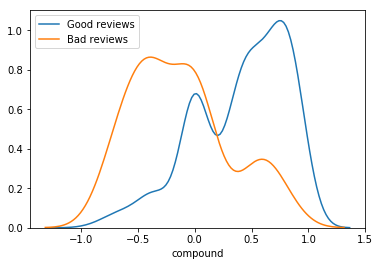

In [19]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

In [20]:
# feature selection
label = "is_bad_review"
ignore_cols = [label, "REL: Comment: Recommend", "review_clean"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)


In [21]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
0,neg,0.072743
3,compound,0.070608
66,word_many,0.066254
10,doc2vec_vector_4,0.055256
9,doc2vec_vector_3,0.054884
8,doc2vec_vector_2,0.044556
60,word_lack,0.038889
4,nb_chars,0.038856
7,doc2vec_vector_1,0.038072
6,doc2vec_vector_0,0.036685


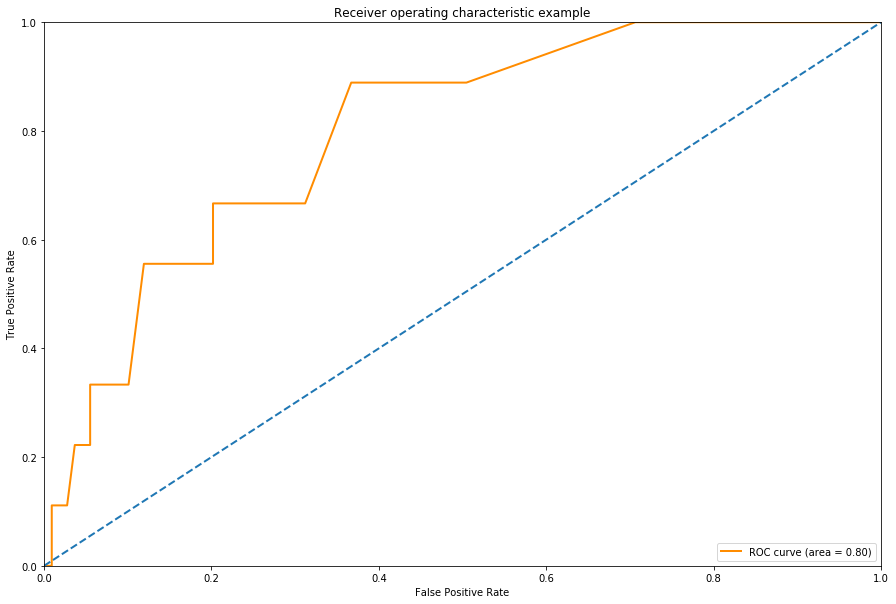

In [22]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Text(0.5,1,'2-class Precision-Recall curve: AP=0.26')

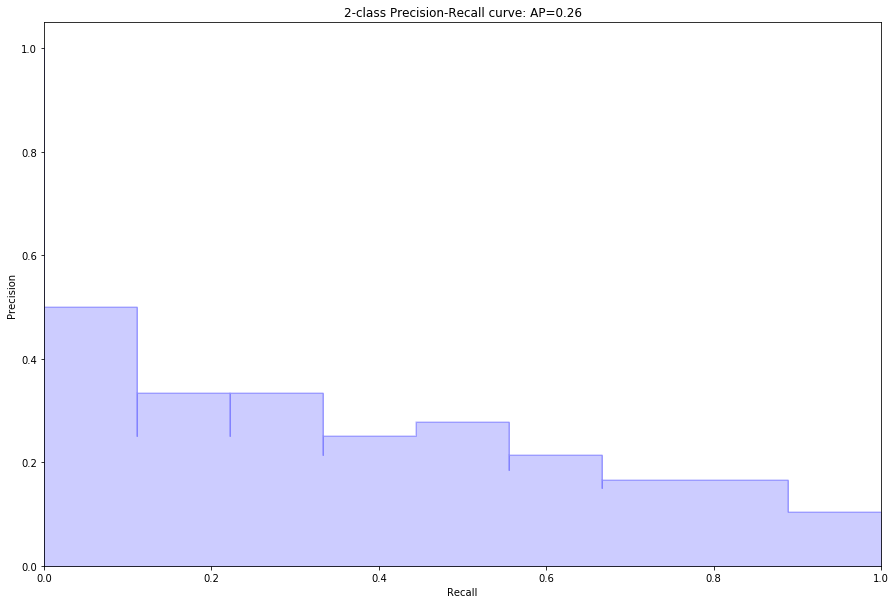

In [23]:
# PR curve

from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.utils.fixes import signature

average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))